In [41]:
from fitness import fitness as fitness_obj
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from tensorflow import keras
from inner_genetic_algorithm import inner_algorithm
from filters.filters import img_filters
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
class MyProblem(ElementwiseProblem):

    def __init__(self, tf_model):
        n_variables = 5
        super().__init__(
            n_var= n_variables, 
            n_obj=2, 
            n_ieq_constr=0, 
            xl= np.zeros(n_variables), 
            xu=np.ones(n_variables)
        )
        self.tf_model = tf_model
          

    def _evaluate(self, x, out, *args, **kwargs):
        algorithm = inner_algorithm(self.tf_model, x)
        X_res, F_res = algorithm.start()

        with open('results/filters_with_param_X.txt', 'a+') as file:
            np.savetxt(file, X_res)
            file.write('\n')

        with open('results/filters_with_param_F.txt', 'a+') as file:
            np.savetxt(file, F_res)
            file.write('\n')
        
        out["F"] = F_res[0]


In [4]:
model = keras.models.load_model('../cifar10_model_90%val_accuracy.h5')
problem = MyProblem(model)

algorithm = NSGA2(
    pop_size=10,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(prob=0.5 ,eta=20),
    eliminate_duplicates=True
)
termination = get_termination("n_gen", 5)

In [5]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=False,
               verbose=True)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      3 |             - |             -
     2 |       20 |      7 |  0.000000E+00 |             f
     3 |       30 |      8 |  0.000000E+00 |             f
     4 |       40 |      8 |  0.2000000000 |         ideal
     5 |       50 |     10 |  0.000000E+00 |             f


In [6]:
with open('results/final_results_X.txt', 'w') as file:
    np.savetxt(file, res.X)
with open('results/final_results_F.txt', 'w') as file:
    np.savetxt(file, res.F)


In [7]:
res.X

array([[0.41919451, 0.68780675, 0.28091716, 0.87811744, 0.02738759],
       [0.09834683, 0.42110763, 0.95788953, 0.53316528, 0.69187711],
       [0.09871304, 0.42110763, 0.95788953, 0.53316528, 0.7499139 ],
       [0.09871838, 0.42641878, 0.96234427, 0.57110054, 0.75013624],
       [0.09834015, 0.38686835, 0.96768084, 0.57213216, 0.69210753],
       [0.09871304, 0.42110763, 0.95784977, 0.6086882 , 0.74992198],
       [0.09871838, 0.42641878, 0.9623045 , 0.57213216, 0.75014431],
       [0.09870636, 0.42618278, 0.96236565, 0.57213216, 0.75014431],
       [0.09834683, 0.40466687, 0.95788953, 0.53316528, 0.69187711],
       [0.09834015, 0.42618278, 0.96236565, 0.57213216, 0.69210753]])

In [8]:
res.F

array([[0.25, 0.35],
       [0.5 , 0.25],
       [0.5 , 0.25],
       [0.5 , 0.25],
       [0.5 , 0.25],
       [0.5 , 0.25],
       [0.5 , 0.25],
       [0.5 , 0.25],
       [0.5 , 0.25],
       [0.5 , 0.25]])

In [83]:
## chromosomes
string_X = None
## fitnesses
string_F = None
with open('results/filters_with_param_X.txt', 'r') as file:
    string_X = file.read()

with open('results/filters_with_param_F.txt', 'r') as file:
    string_F = file.read()

In [98]:
chromosomes_filter = np.fromstring(string_X.split('\n')[-3], sep=' ')
chromosome_fitness = np.fromstring(string_F.split('\n')[-3], sep=' ')

In [107]:
def get_filter_function(filter_gene, filter_alpha, filter_strength):
    """
    get the filter function
    """
    ## to choose the filter
    # if 0 < filter_gene <= 0.25:
    if filter_gene == 0 :
        filter_name = 'kelvin'
    # elif 0.25 < filter_gene <= 0.5:
    elif filter_gene == 1:
        filter_name = 'clarendon'
    # elif 0.5 < filter_gene <= 0.75:
    elif filter_gene == 2:
        filter_name = 'moon'
    # elif 0.75 < filter_gene <= 1:
    elif filter_gene == 3:
        filter_name = 'sharpening'
    else:
        raise ValueError(f'filter chromosome value should be integer values between 0 to 3, entered value: {filter_gene}')
    
    print(f'Filter name: {filter_name}')
    
    filter_function = img_filters(filter_alpha, filter_strength, filter_name )
    return filter_function

In [108]:
## the index of parameters of each filter
# parameter_index = {
#     0: [5, 6],
#     1: [7, 8],
#     2: [9, 10],
#     3: [11, 12],
#     4: [13, 14]
# }

parameter_index = {
    0: [4, 5],
    1: [6, 7],
    2: [8, 9],
    3: [10, 11],
    # 4: [13, 14]
}

functions_arr = []
for i in range(4):
    filter_gene = chromosomes_filter[i]
    filter_alpha_gene = chromosomes_filter[parameter_index[i][0]]
    filter_strength_gene = chromosomes_filter[parameter_index[i][1]]

    filter_function = get_filter_function(filter_gene, filter_alpha_gene, filter_strength_gene)
    functions_arr.append(filter_function)

Filter name: moon
Filter name: kelvin
Filter name: clarendon
Filter name: sharpening


In [109]:
def apply_multiple_filters(filter_functions, images_batch):
    """
    apply multiple filters on one image
    filter_functions are the multiple filters function extracted from a chromosome 

    returns the manipulated images (filtered ones)
    """
    ## filtered images are saved in the array
    manipulated_images_arr = []

    ## for images
    for image in images_batch:
        manipulated_image = np.copy(image)

        ## Apply multiple filters to the image
        for filter_func in filter_functions:
            manipulated_image = filter_func.apply(manipulated_image)
        
        manipulated_images_arr.append(manipulated_image)
    ## convert back to numpy array
    manipulated_images_arr = np.array(manipulated_images_arr)
    
    return manipulated_images_arr

In [110]:
(x_train, _), (_, _) = keras.datasets.cifar10.load_data()

In [115]:
images_manipulated = apply_multiple_filters(functions_arr, x_train[:20])

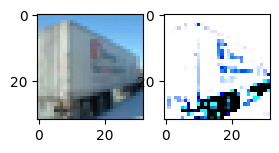

In [116]:
index_image = 15

plt.figure(figsize=(3, 3))
plt.subplot(121)
plt.imshow(x_train[ index_image ])
plt.subplot(122)
plt.imshow(images_manipulated[ index_image ])
plt.show()

In [ ]:
## TODO: Find a function rather than sharpening
## because it can destort the image as can be seen above 